# VaR Example calculation
Let's start with the same portfolio of the Markowitz exercise:

In [1]:
from pandas_datareader import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Time series download
We will download the time series of three ETFs from yahoo finance

In [2]:
eustoxx600 = data.DataReader("EXSA.MI", 
                       start='2018-11-15', 
                       end='2019-11-15', 
                       data_source='yahoo')['Adj Close']

In [3]:
sp500 = data.DataReader("XSPX.MI", 
                       start='2018-11-15', 
                       end='2019-11-15', 
                       data_source='yahoo')['Adj Close']

In [4]:
emerging = data.DataReader("EMKT.MI", 
                       start='2018-11-15', 
                       end='2019-11-15', 
                       data_source='yahoo')['Adj Close']

## Weekly data
Let us resample our database at weekly time scale (like we did before)

In [5]:
wk_euro=eustoxx600.resample('W').last()
wk_us=sp500.resample('W').last()
wk_emg=emerging.resample('W').last()

We have now weekly data. Let us calculate parametric VaR

In [6]:
ptf=pd.DataFrame({'eu': np.log(wk_euro).diff(), 'us': np.log(wk_us).diff(), 'emg' : np.log(wk_emg).diff()})

## Parametric VaR
Let's look to Parametric VaR in a yearly time horizon, but with different data: a weekly or daily time series.

In [7]:
CovMatrixDF=ptf.cov()

In [8]:
CovMatrix=52*CovMatrixDF.values

In [9]:
CovMatrix

array([[0.0138104 , 0.01557703, 0.01340294],
       [0.01557703, 0.02316381, 0.01709364],
       [0.01340294, 0.01709364, 0.02319908]])

Now suppose we have the following portfolio weights:

In [10]:
wgt=[0.5,0.3,0.2]

Now we have everything to calculate VaR. Usually is not a safe nor goot idea to draw average future returns from time series, so we will assume 0 central return for the rest of the exercise.

In [11]:
-norm.ppf(0.95)*np.dot(wgt,np.dot(wgt,CovMatrix))**0.5

-0.20721394843296131

So, if we consider that our central return is 0 (common assumption when you reason with parametric VaR) our **parametric VaR at 95% with 1 year time horizon** is about **20.7%**
Let's look at what happens if we look at a different time scale...

In [12]:
ptf2=pd.DataFrame({'eu': np.log(eustoxx600).diff(), 'us': np.log(sp500).diff(), 'emg' : np.log(emerging).diff()})

In [13]:
CovMatrix2=250*ptf2.cov().values

In [14]:
-norm.ppf(0.95)*np.dot(wgt,np.dot(wgt,CovMatrix2))**0.5

-0.22557592258277107

Using a **daily base** instead of a weekly base we have a **parametric VaR of 22.6%**: notice that our VaR figure changed of 10%! Let's look at historical VaR:

In [15]:
ptf2_returns=np.dot(wgt,ptf2.values.transpose()).transpose()

In [16]:
ptf2_returns

array([            nan, -5.03366366e-04, -9.14922780e-03, -1.31600706e-02,
        1.12982746e-02, -9.96767390e-03,  5.99942034e-03,  1.07122464e-02,
        2.12666301e-03,  3.69282188e-03,  4.67206748e-03, -6.05176210e-04,
        1.43523095e-02, -5.89527924e-03, -1.47777888e-02, -3.54495943e-02,
        1.09425166e-02, -2.19676465e-02,  2.08292310e-02,  1.21997049e-02,
       -3.48822835e-03, -6.99755650e-03, -1.25742092e-02, -1.10484283e-02,
        2.36460311e-03, -1.99642453e-02, -3.79703426e-04, -1.67756265e-02,
        1.77135051e-02,  6.26724634e-03, -1.35404589e-02,  2.44739159e-02,
        7.47306239e-04,  7.90136776e-03,  7.03994406e-03,  8.50915144e-04,
        3.63705800e-03, -5.38884133e-03,  1.03261634e-02,  6.32919490e-03,
        1.18619620e-03,  1.85052102e-02, -3.61702105e-03, -4.99645435e-03,
       -3.04019522e-03,  5.96830205e-03,  6.12988542e-03, -1.18952322e-02,
        4.74581210e-03,  5.76599356e-03,  8.24373090e-03,  9.11782995e-04,
        2.26554400e-03,  

We have **nans**!!! Let us clean the time series...

In [17]:
ptf2_returns=ptf2_returns[np.logical_not(np.isnan(ptf2_returns))]
ptf2_returns=ptf2_returns-np.mean(ptf2_returns)

Let us look to historgram of returns:

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  3.,  4., 13.,  9., 40.,
        52., 58., 34., 23.,  2.,  5.,  2.]),
 array([-0.05393517, -0.05004237, -0.04614957, -0.04225677, -0.03836398,
        -0.03447118, -0.03057838, -0.02668558, -0.02279278, -0.01889998,
        -0.01500718, -0.01111438, -0.00722158, -0.00332878,  0.00056401,
         0.00445681,  0.00834961,  0.01224241,  0.01613521,  0.02002801,
         0.02392081]),
 <a list of 20 Patch objects>)

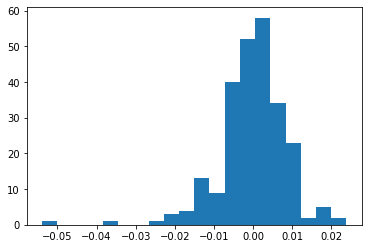

In [18]:
plt.hist(ptf2_returns,bins=20)

Quite different from normal! We have cleaned daily returns (non NaN and zero mean)... let's look at historical VaR:

In [19]:
np.percentile(ptf2_returns,5)

-0.013960430647339348

Let's get to yearly time horizon (square root rule again...):

In [20]:
np.percentile(ptf2_returns,5)*(250**0.5)

-0.22073378981205602

So **historical VaR is -22.07%**